In [1]:
import os
import re
import pandas as pd
import numpy as np
from skimage import measure
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage import exposure, filters
from sklearn import metrics

/home/mr1142/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-09-20 16:12:32.928482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# FUNCIONES

In [3]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)

def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask


def list_files(path):
    return [f for f in os.listdir(path) 
                if os.path.isfile(os.path.join(path, f))]

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return 0.6*abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + loss2
    return loss


def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 2)
    img = np.uint8(img)
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def get_prepared_img(img, pix, mask = True, clahe_bool = False):
    img = recolor_resize(img, pix)
    if clahe_bool:
        img = clahe(img)
    img = normalize(img)
    return img

# CARGAR DATOS

In [4]:
import os
import re
import cv2
import pickle
import h5py as f
import pandas as pd

**ACIL**

In [5]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math

class DataGenerator(Sequence):
    
    def __init__(self, x_set, y_set, batch_size, pix, index, mask= False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.pix = pix
        self.index = index
        self.mask = mask

    def __len__(self):
        # numero de batches
        return math.ceil(len(self.index) / self.batch_size)

    def __getitem__(self, idx):
        # idx: numero de batch
        # batch 0: idx = 0 -> [0*batch_size:1*batch_size]
        # batch 1: idx = 1 -> [1*batch_size:2*batch_size]
        # Lo que hago es recorrer el indice
        index = self.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        index.sort()
        temp_x = self.x[index]
        batch_y = self.y[index]
        batch_x = np.zeros((temp_x.shape[0], self.pix, self.pix, 1))
        for i in range(temp_x.shape[0]):
            try:
                batch_x[i] = get_prepared_img(temp_x[i], self.pix, self.mask)
            except:
                img = np.random.randint(0,255,self.pix*self.pix).reshape((self.pix, self.pix, 1))
                batch_x[i] = normalize(img)
                print('e')
        return np.array(batch_x), np.array(batch_y)

In [6]:
def generate_index(subset_bool = False, trainprop = 0.8):
    if subset_bool:
        with open("/home/mr1142/Documents/img_class/indices/train_subset", "rb") as fp:
            index = pickle.load(fp)
    else:
        with open("/home/mr1142/Documents/img_class/indices/train", "rb") as fp:
            index = pickle.load(fp)

    np.random.shuffle(index)
    idtrain = index[:int(len(index)*trainprop)]
    idtest = index[int(len(index)*trainprop):]

    return idtrain, idtest

In [7]:
# DATAFRAME
df = f.File("/home/rs117/covid-19/data/cxr_consensus_dataset_nocompr.h5", "r")
for key in df.keys():
    globals()[key] = df[key]

# DATA GENERATORS
idtrain, idtest = generate_index()
# np.random.shuffle(idtrain)
# np.random.shuffle(idtest)
# idtrain = idtrain[0:5000]
# idtest = idtest[0:5000]

**PEDIATRIC**

In [8]:
def create_dataframe(folder, path = '/home/mr1142/Documents/Data/chest_xray'):
    path = os.path.join('/home/mr1142/Documents/Data/chest_xray', folder)
    for fold in os.listdir(path):
        globals()[fold] = {}
        imgs = os.listdir(os.path.join(path, fold))
        globals()[fold]['path'] = [os.path.join(path, fold)] * len(imgs)
        globals()[fold]['img_name'] = imgs
        globals()[fold]['normal'] = [1 if fold == 'NORMAL' else 0 for _ in range(len(imgs))]
        globals()[fold]['viral'] = [1 if re.search('virus', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['bacteria'] = [1 if re.search('bacteria', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['real'] = [0 if fold == 'NORMAL' else 1 if re.search('virus', imgs[i]) else 2 for i in range(len(imgs))]

    for k, v in PNEUMONIA.items():
        v.extend(NORMAL[k])

    df = pd.DataFrame(PNEUMONIA)

    return df

In [9]:
ped = create_dataframe('train')

# TRANSFORMERS

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/home/mr1142/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [9]:
pixels = 256

In [10]:
learning_rate = 1e-4
weight_decay = 1e-5
batch_size = 8
num_epochs = 20
image_size = pixels  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32 # Como se van a transformar los patchs (en este caso 256 -> 32)
num_heads = 4 # Cuantas Head Attention paralelas
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 5 # Cuantas veces se va a aplicar el esquema de encoding (headattention + feed forward)
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
num_classes = 3
input_shape = (pixels, pixels, 1)

# x_train_paths = [os.path.join(ped.path[i], ped.img_name[i]) for i in ped.index]
# y_train = np.array(ped[['normal', 'viral', 'bacteria']])

In [12]:
# x_train = np.zeros((1500,pixels,pixels,1))
# for i in range(x_train.shape[0]):
#     x_train[i,...] = get_prepared_img(cv2.imread(x_train_paths[i]), pixels)

In [13]:
traingen = DataGenerator(X_train, y_train, batch_size, pixels, idtrain)
testgen = DataGenerator(X_train, y_train, batch_size, pixels, idtest)

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

2022-09-20 16:12:39.080357: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 16:12:39.081460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-20 16:12:39.147236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-20 16:12:39.147275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-20 16:12:39.149903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-20 16:12:39.149948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

(1, 256, 256)
Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 256


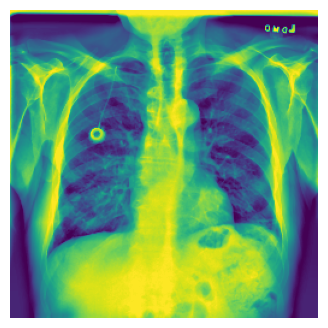

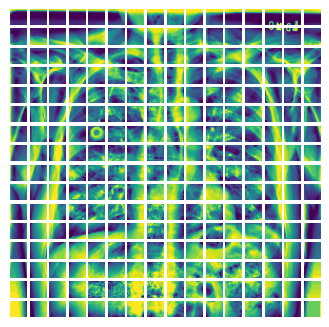

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = traingen[np.random.choice(range(len(traingen)))][0][0,...]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(patches.shape)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

(256, 256)


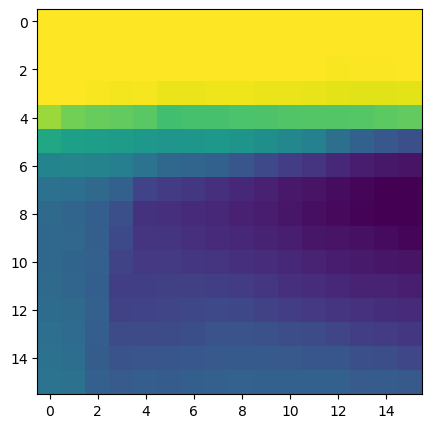

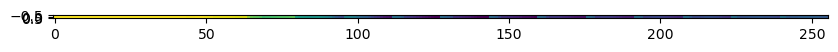

In [17]:
print(patches[0].shape)
plt.figure(figsize=(5,5))
plt.imshow(tf.reshape(patches[0][10], (16,16)))
plt.figure(figsize=(10,20))
plt.imshow(tf.reshape(patches[0][10], (1,256)))

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [19]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    print(inputs.shape)
    # # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    print(patches.shape)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [20]:
model = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

(None, 256, 256, 1)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, None, 256)


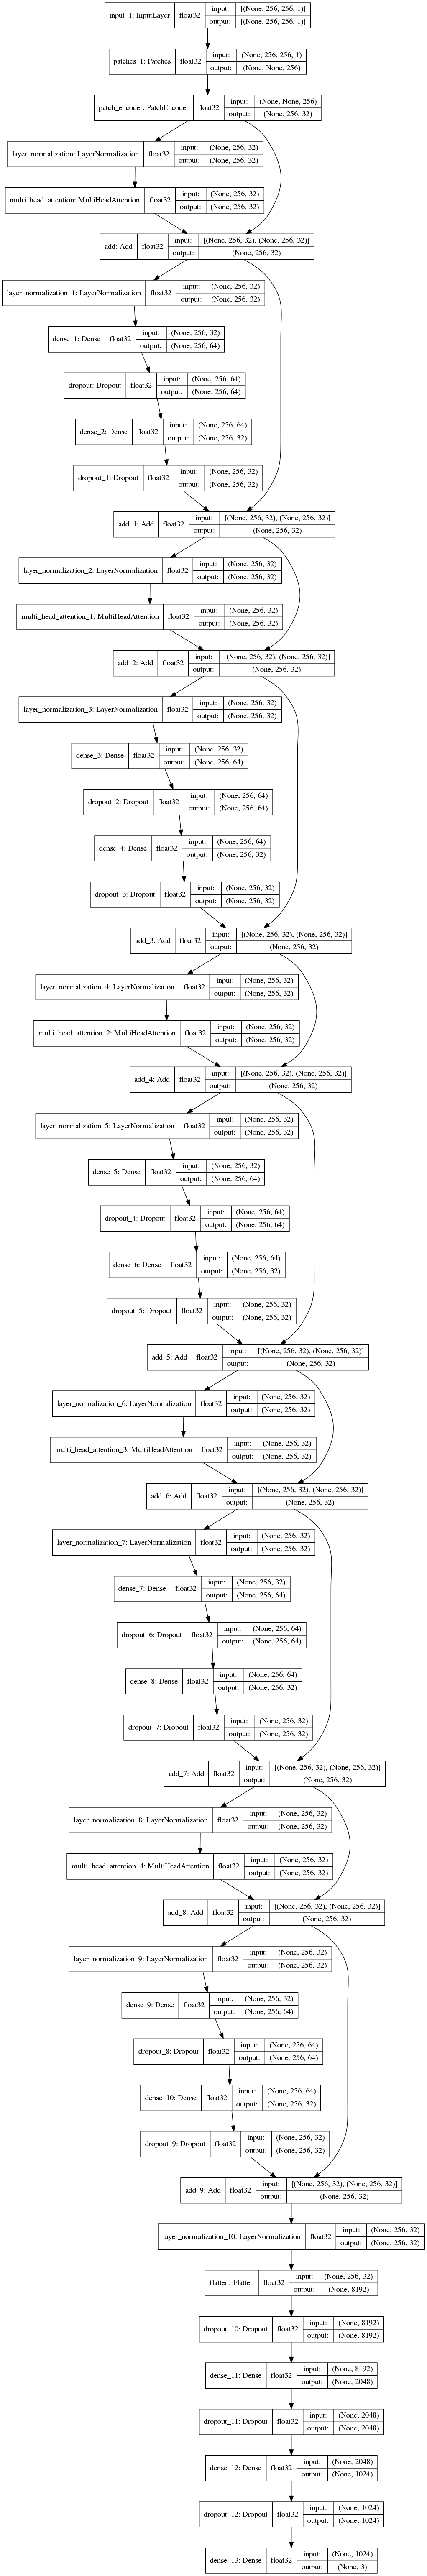

In [21]:
tf.keras.utils.plot_model(model, to_file = 'model.png', show_shapes=True,
    show_dtype=True)

In [49]:
history = model.fit(traingen,
    validation_data = testgen,
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/20
 414/3209 [==>...........................] - ETA: 26:39 - loss: 3.1658 - accuracy: 0.5425

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")